## IMPORTS

In [1]:
import tensorflow as tf
import os
from glob import glob
!pip install -q tensorflow-io
import tensorflow_io as tfio


from matplotlib import pyplot as plt

from IPython import display
import imageio

import numpy as np
import math
import tensorflow.keras.preprocessing.image as prep


from copy import copy
import matplotlib.colors as colors

## HYPERPARAMETERS

## Read dataset from train and validation tfrecords (change to MNIST dataset)

In [2]:
# # paths for the tfrecords
# # # # # for train
# train_positive =  "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/train_positive_samples_win.tfrecords"
# train_negative =  'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/train_negative_samples_win.tfrecords'

# # for val
# val_positive =  "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/val_positive_samples_win.tfrecords"
# val_negative =  'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/val_negative_samples_win.tfrecords'

# # for windows
# train_positive_file_name =  "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/train_positive_sample_pairs_win.tfrecords"
# train_negative_file_name =  'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/train_negative_sample_pairs_win.tfrecords'

# val_positive_file_name =  "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/val_positive_sample_pairs_win.tfrecords"
# val_negative_file_name =  'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/val_negative_sample_pairs_win.tfrecords'
# # for ubuntu

train_positive_file_name =  "/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train_positive_sample_pairs_ubuntu.tfrecords"
train_negative_file_name =  '/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train_negative_sample_pairs_ubuntu.tfrecords'
 
val_positive_file_name =  "/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/val_positive_sample_pairs_ubuntu.tfrecords"
val_negative_file_name =  '/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/val_negative_sample_pairs_ubuntu.tfrecords'


train_positive_dataset = tf.data.TFRecordDataset(train_positive_file_name)
train_negative_dataset = tf.data.TFRecordDataset(train_negative_file_name)

val_positive_dataset = tf.data.TFRecordDataset(val_positive_file_name)
val_negative_dataset = tf.data.TFRecordDataset(val_negative_file_name)


# fashion_mnist = tf.keras.datasets.fashion_mnist

# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()




In [3]:
# print(train_images.shape)
# print(test_images.shape)

# print("initial range:[{},{}]".format(train_images.min(), train_images.max()))
# # directly normalize
# train_images = train_images/255.0
# print("normalized range:[{},{}]".format(train_images.min(), train_images.max()))
# test_images = test_images/255.0


# print("range of targest[{}, {}]".format(train_labels.min(), train_labels.max()))

In [4]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# for tx_input, tx_target in train_dataset.take(1):
#     print("range:[{},{}]".format(tx_input.numpy().min(), tx_input.numpy().max()))
#     print(tx_input.shape)
#     plt.figure()
#     plt.imshow(tx_input)
#     plt.colorbar()
#     plt.grid(False)
#     plt.title(str(tx_target.numpy()))
#     plt.show()
    
# for tx_input, tx_target in test_dataset.take(1):
#     print("range:[{},{}]".format(tx_input.numpy().min(), tx_input.numpy().max()))
#     print(tx_input.shape)
#     plt.figure()
#     plt.imshow(tx_input)
#     plt.colorbar()
#     plt.grid(False)
#     plt.title(str(tx_target.numpy()))
#     plt.show()

## PREPROCESSING

In [5]:
BUFFER_SIZE = 2048
BATCH_SIZE = 2
IMG_WIDTH = 256
IMG_HEIGHT = 256
# IMG_WIDTH = 28
# IMG_HEIGHT = 28
# project_name
project_name = "300Cls256_OneShotShareRandFlipScrachStructuredBleedClassifierNoResampleONlyOutMid/"

# class names for the classification
# Class_names= ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Class_names = ["No bleed", "bleed"]

if not os.path.exists(project_name):
    os.makedirs(project_name)
# tb_log_name 
log_dir=project_name + "AE_logs/"

# image_save name
train_save_figure_path = project_name + "AE_saves/train"
test_save_figure_path = project_name + "AE_saves/test"

# training_checkpoint name
checkpoint_dir = project_name + "training_checkpoints"

# model architecture name
encoder_path = project_name + "Encoder.png"
decoder_path = project_name +"Decoder.png"
autoencoder_path = project_name + "Autoencoder.png"
new_model_path = project_name + "new_model.png"
base_model_path = project_name + "base_model.png"
classifier_path = project_name + "classifier.png"
# gif save name
anim_file = project_name + 'AE_saves.gif'

# # dicom root 
# dicom_root = 'E:/dataset/Leisang/myTry/BleedingDataDCM'

In [6]:
import math as m
# import tensorflow_addons as tfa

def resize(input, target):
    print(input.shape)
    print(target.shape)
    resized_input = tf.image.resize(input, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_target = tf.image.resize(target, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_input =  tf.reshape(resized_input, [IMG_HEIGHT, IMG_WIDTH, 1])
    resized_target =  tf.reshape(resized_target, [IMG_HEIGHT, IMG_WIDTH, 1])
    return  resized_input, resized_target

# @tf.function()
def truncate(x, min, max):
#     print(x.shape)
    cliped =  tf.clip_by_value(x, min, max)
    return cliped
 
def norm(x, min, max):
    # normalize_value = (value − min_value) / (max_value − min_value)
    tensor = tf.math.divide(tf.subtract(x, min),
                    tf.subtract(max, min))
    return tensor

def linear_normalization(input, min=30720.0, max=34816.0):
    truncated_input = truncate(input, min, max)
    norm_input = norm(truncated_input, min, max )
    return  norm_input


def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 1])  # crop to 256x256

    return cropped_image[0], cropped_image[1]

@tf.function()
def random_jitter(input_image_tuple, seg_labels_tuple):
    # randomly cropping to 256 x 256 x 3
#     input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image1 = tf.image.flip_left_right(input_image_tuple[0])
        input_image2 = tf.image.flip_left_right(input_image_tuple[1])
        input_image3 = tf.image.flip_left_right(input_image_tuple[2])
        seg_label1 = tf.image.flip_left_right(seg_labels_tuple[0])
        seg_label2 = tf.image.flip_left_right(seg_labels_tuple[1])
        seg_label3 = tf.image.flip_left_right(seg_labels_tuple[2])

    return (input_image1, input_image2, input_image3), (seg_label1, seg_label2, seg_label3)



In [7]:
# parser the dataset to decode the features
# Create a dictionary describing the features.
image_feature_description = {
    
        'dicom_path1': tf.io.FixedLenFeature([], tf.string),
        'seg_label1': tf.io.FixedLenFeature([], tf.string), 
        'cls_label1': tf.io.FixedLenFeature([], tf.int64),
        
        'dicom_path2': tf.io.FixedLenFeature([], tf.string),
        'seg_label2': tf.io.FixedLenFeature([], tf.string), 
        'cls_label2': tf.io.FixedLenFeature([], tf.int64),
        
        'dicom_path3': tf.io.FixedLenFeature([], tf.string),
        'seg_label3': tf.io.FixedLenFeature([], tf.string), 
        'cls_label3': tf.io.FixedLenFeature([], tf.int64),
}

def read_inputs_seg_labels(parsed_features, dicom_path_key, seg_label_key):
    # decode dicom
    dicom_path = parsed_features[dicom_path_key]
    image_bytes = tf.io.read_file(dicom_path)
    input_image = tf.cast(tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16), tf.float32)
    # decode mask
    seg_label = tf.cast(tf.io.decode_raw(parsed_features[seg_label_key], tf.uint8), tf.float32)
    seg_label = tf.reshape(seg_label, [-1, 512,512,1])
    
    return dicom_path, input_image, seg_label

def train_prerpocessing(input_image_tuple, seg_labels_tuple):
    preproced_inputs = []
    preproced_input_w_images = []
    preproced_labels = []
    
      # 1nd random flip
    input_image_tuple, seg_labels_tuple = random_jitter(input_image_tuple, seg_labels_tuple)

    
    for i in range(len(input_image_tuple)):
    
        input_image, seg_label = resize(input_image[i], seg_label[i])
        print(input_image.shape)
        print(seg_label.shape)
        
        # Last normalize
        norm_input_image = linear_normalization(input_image) 
        seg_label =  seg_label/255.0


        #lei -window for showing only
        input_w_image = linear_normalization(input_image, min=32788.0, max=33148.0)
        
        preproced_inputs.append(input_image)
        preproced_input_w_images.append(norm_input_image)
        preproced_labels.append(seg_label)
        
        
    
    
    return preproced_inputs, preproced_input_w_images, preproced_labels

def test_prerpocessing(input_image_tuple, seg_labels_tuple):
    preproced_inputs = []
    preproced_input_w_images = []
    preproced_labels = []
    for i in range(len(input_image_tuple)):
        
    
        input_image, seg_label = resize(input_image[i], seg_label[i])
        print(input_image.shape)
        print(seg_label.shape)
        
        # Last normalize
        norm_input_image = linear_normalization(input_image) 
        seg_label =  seg_label/255.0


        #lei -window for showing only
        input_w_image = linear_normalization(input_image, min=32788.0, max=33148.0)
        
        preproced_inputs.append(input_image)
        preproced_input_w_images.append(norm_input_image)
        preproced_labels.append(seg_label)
        
    return preproced_inputs, preproced_input_w_images, preproced_labels

# # @tf.function()
def train__parse_image_function(example_proto):
    # extract features # Parse the input tf.Example proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, image_feature_description)
       
  # for input 1 --->
#     # decode dicom
#     dicom_path1 = parsed_features["dicom_path1"]
#     image_bytes1 = tf.io.read_file(dicom_path1)
#     input_image1 = tf.cast(tfio.image.decode_dicom_image(image_bytes1, dtype=tf.uint16), tf.float32)
#     # decode mask
#     seg_label1 = tf.cast(tf.io.decode_raw(parsed_features['seg_label1'], tf.uint8), tf.float32)
#     seg_label1 = tf.reshape(seg_label1, [-1, 512,512,1])
    dicom_path1, input_image1, seg_label1 = read_inputs_seg_labels(parsed_features, "dicom_path1", "seg_label1")
    
    # for input 2 --->
    dicom_path2, input_image2, seg_label2 = read_inputs_seg_labels(parsed_features, "dicom_path2", "seg_label2")
    
    # for input 3 --->
    dicom_path3, input_image3, seg_label3 = read_inputs_seg_labels(parsed_features, "dicom_path3", "seg_label3")
    
    
    inputs = (input_image1, input_image2, input_image3)
    seg_labels = (seg_label1, seg_label2, seg_label3)
    
    # preprocessing--->
    # for input 1 ------->
    preproced_inputs, preproced_input_w_image, preproced_labels = train_prerpocessing(inputs, seg_labels)
    

    
    
    
    
    return (dicom_path1, dicom_path2, dicom_path3), tuple(preproced_inputs), tuple(preproced_input_w_image), tuple(preproced_labels), (parsed_features["cls_label1"], parsed_features["cls_label2"], parsed_features["cls_label3"])

# @tf.function()
def test__parse_image_function(example_proto):
    # extract features # Parse the input tf.Example proto using the dictionary above.(dicom_path1, dicom_path2, dicom_path3), (input_image1, input_image2, input_image3), (seg_label1, seg_label2, seg_label3), (parsed_features["cls_label1"], parsed_features["cls_label2"], parsed_features["cls_label3"]
    parsed_features = tf.io.parse_single_example(example_proto, image_feature_description)
    
    # for input 1 --->
    dicom_path1, input_image1, seg_label1 = read_inputs_seg_labels(parsed_features, "dicom_path1", "seg_label1")
    
    # for input 2 --->
    dicom_path2, input_image2, seg_label2 = read_inputs_seg_labels(parsed_features, "dicom_path2", "seg_label2")
    
    # for input 3 --->
    dicom_path3, input_image3, seg_label3 = read_inputs_seg_labels(parsed_features, "dicom_path3", "seg_label3")
    
    
    # preprocessing--->
    # for input 1 ------->
    norm_input_image1, input_w_image1, seg_label1 = test_prerpocessing(input_image1, seg_label1)
    
    # for input 2------->
    norm_input_image2, input_w_image2, seg_label2 = test_prerpocessing(input_image2, seg_label2)
    
    # for input 3------->
    norm_input_image3, input_w_image3, seg_label3 = test_prerpocessing(input_image3, seg_label3)
    
    
    return (dicom_path1, dicom_path2, dicom_path3), (norm_input_image1, norm_input_image2, norm_input_image3), (input_w_image1, input_w_image2, input_w_image3), (seg_label1, seg_label2, seg_label3), (parsed_features["cls_label1"], parsed_features["cls_label2"], parsed_features["cls_label3"])


# train: positive
# train_nb_pos = 3049
# train_nb_neg = 33588
train_nb_pos = 3048
train_nb_neg = 33515
parsed_train_positive_dataset = train_positive_dataset.map(train__parse_image_function)
parsed_train_negative_dataset = train_negative_dataset.map(train__parse_image_function)

# val_nb_pos = 238
# val_nb_neg = 4420
val_nb_pos = 238
val_nb_neg = 4214
parsed_val_positive_dataset = val_positive_dataset.map(test__parse_image_function)
parsed_val_negative_dataset = val_negative_dataset.map(test__parse_image_function)

(None, None, None, None)
(None, 512, 512, 1)
after resize: (256, 256, 1)
after resize: (256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(None, None, None, None)
(None, 512, 512, 1)
after resize: (256, 256, 1)
after resize: (256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(None, None, None, None)
(None, 512, 512, 1)
after resize: (256, 256, 1)
after resize: (256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(None, None, None, None)
(None, 512, 512, 1)
after resize: (256, 256, 1)
after resize: (256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(None, None, None, None)
(None, 512, 512, 1)
after resize: (256, 256, 1)
after resize: (256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(None, None, None, None)
(None, 512, 512, 1)
after resize: (256, 256, 1)
after resize: (256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(None, None, None, None)
(None, 512, 512, 1)
(256, 256, 1)
(256, 256, 1)
(None, None, None, None)
(None, 512, 512, 1)
(256, 256, 1)
(256, 256, 1)
(None, None, None, None)
(None, 512, 512, 1)
(256, 256, 1)
(256, 256, 1)
(None, 

input range: [0.0 0.94580078125]
dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train/ZA-006_000/00001163.DCM', shape=(), dtype=string)
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)

norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.0, 0.0]
input range: [0.0 0.94580078125]
dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train/ZA-006_000/00001164.DCM', shape=(), dtype=string)
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(1, shape=(), dtype=int64)

norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.3194444179534912]
masked range:[1.1333333253860474, 1.3194444179534912]
input range: [0.0 0.94384765625]
dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train/ZA-006_000/00001165.DCM', shape=(), dtype=string)
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(1, shape

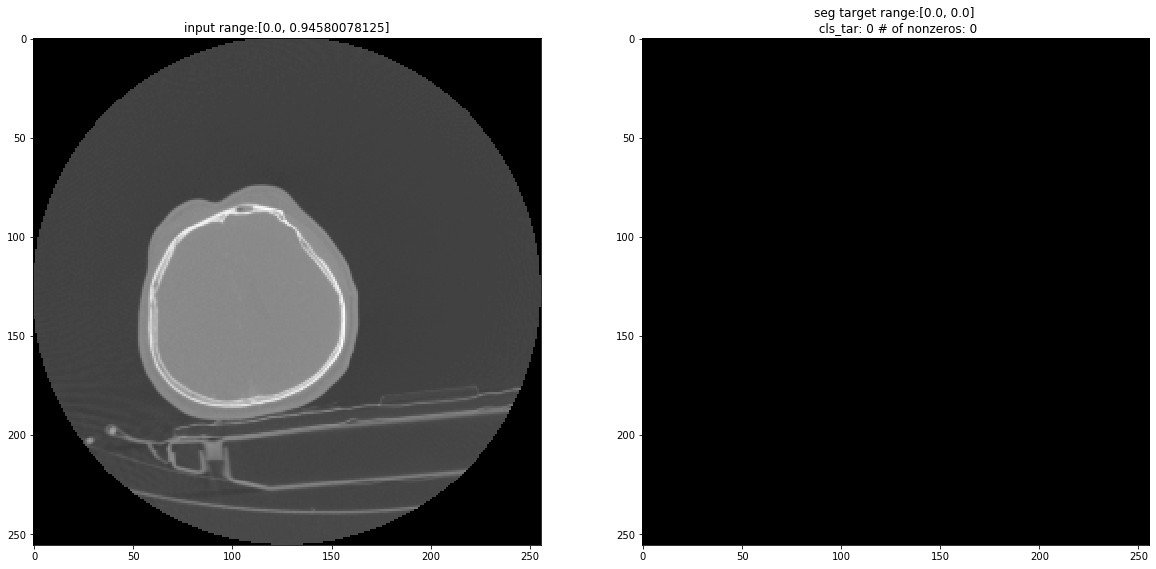

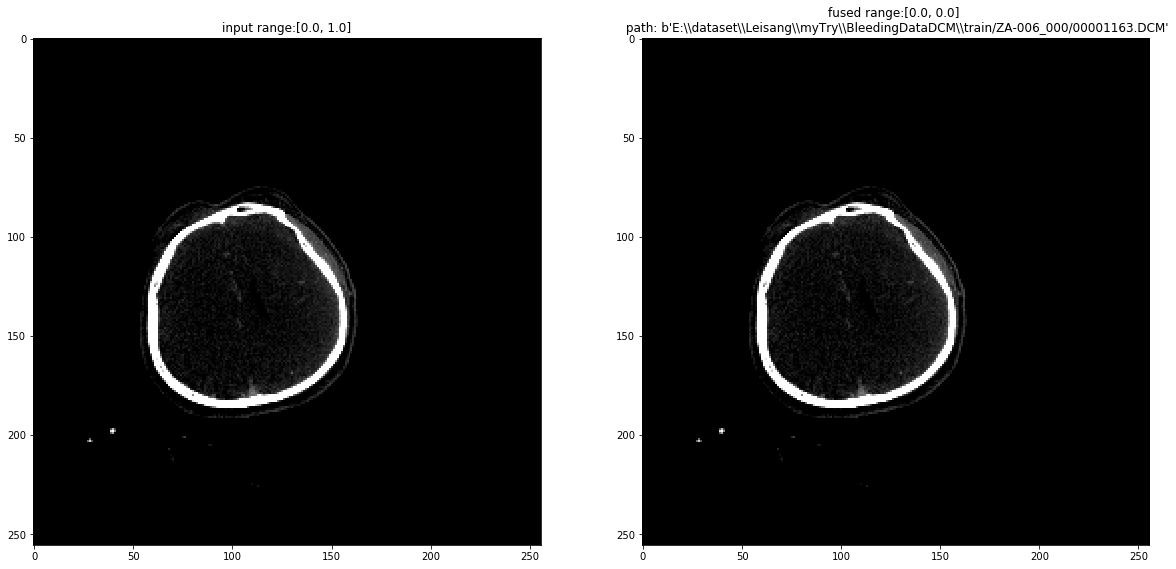

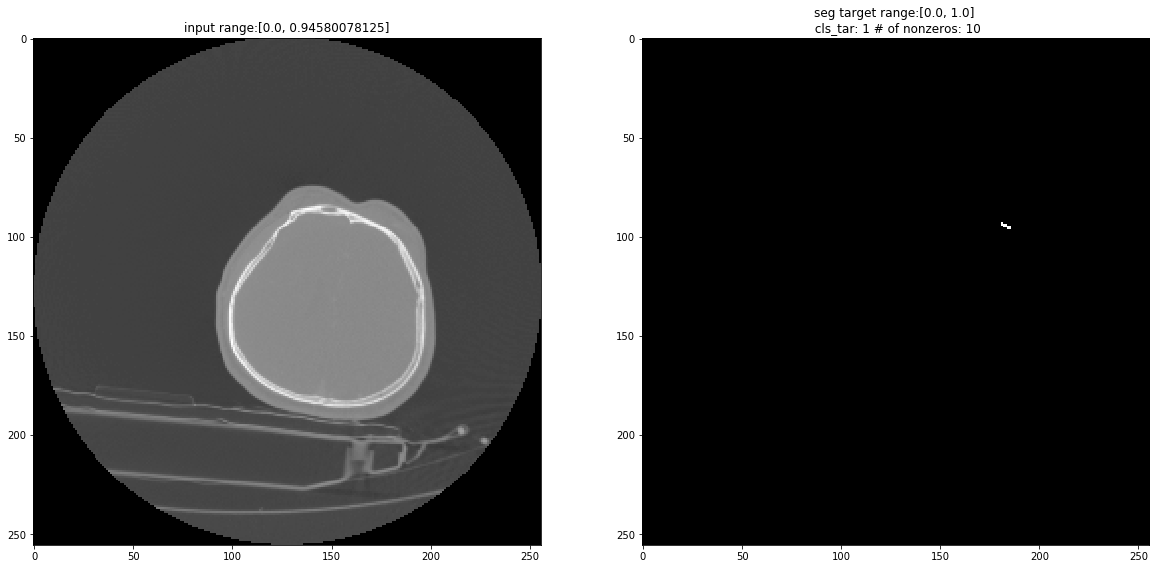

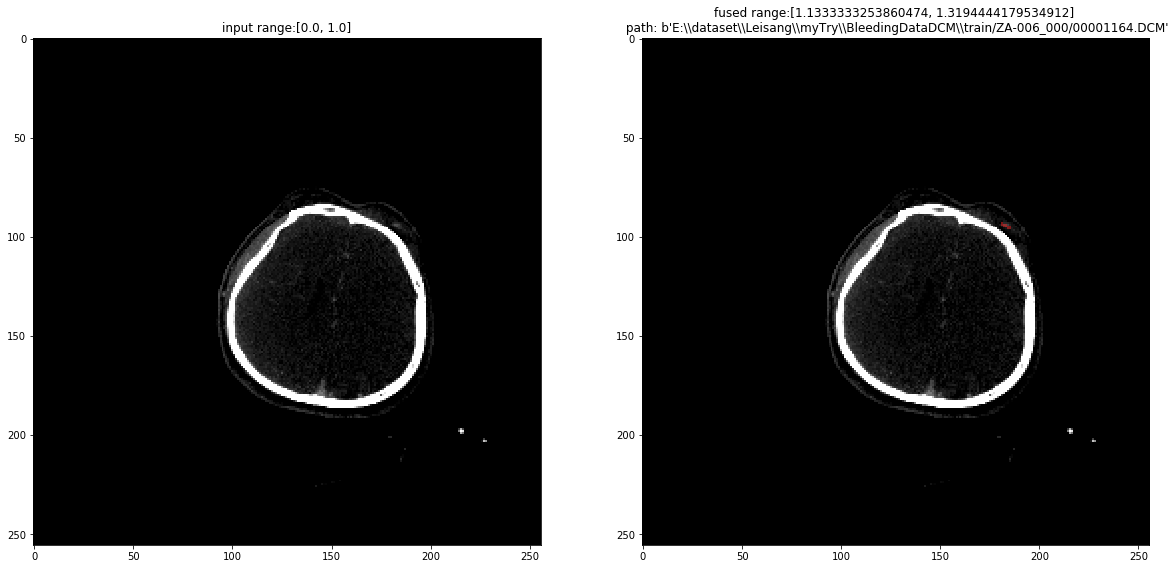

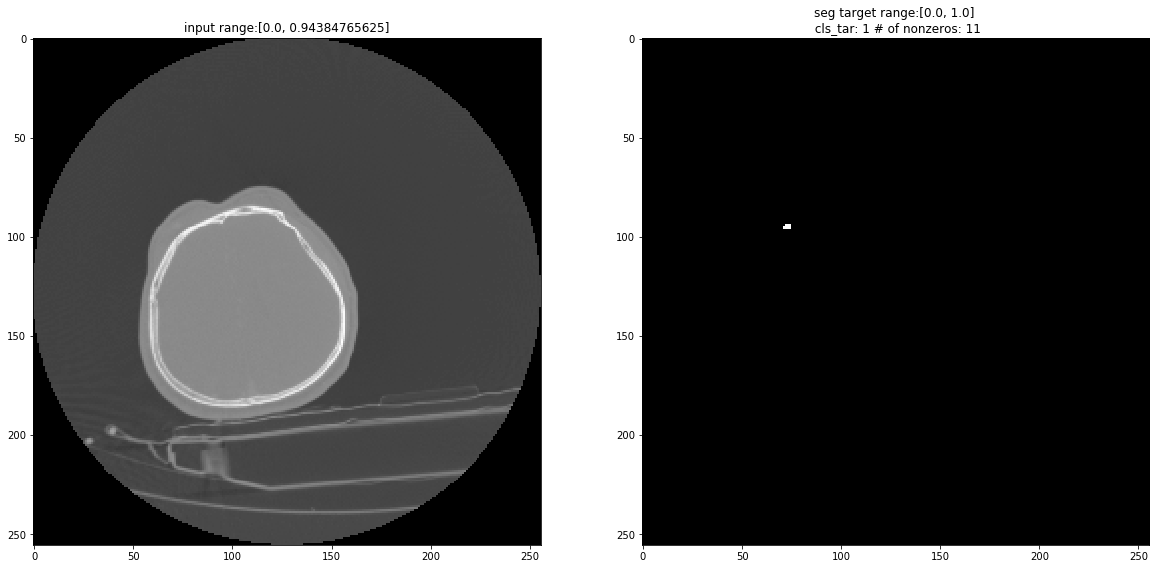

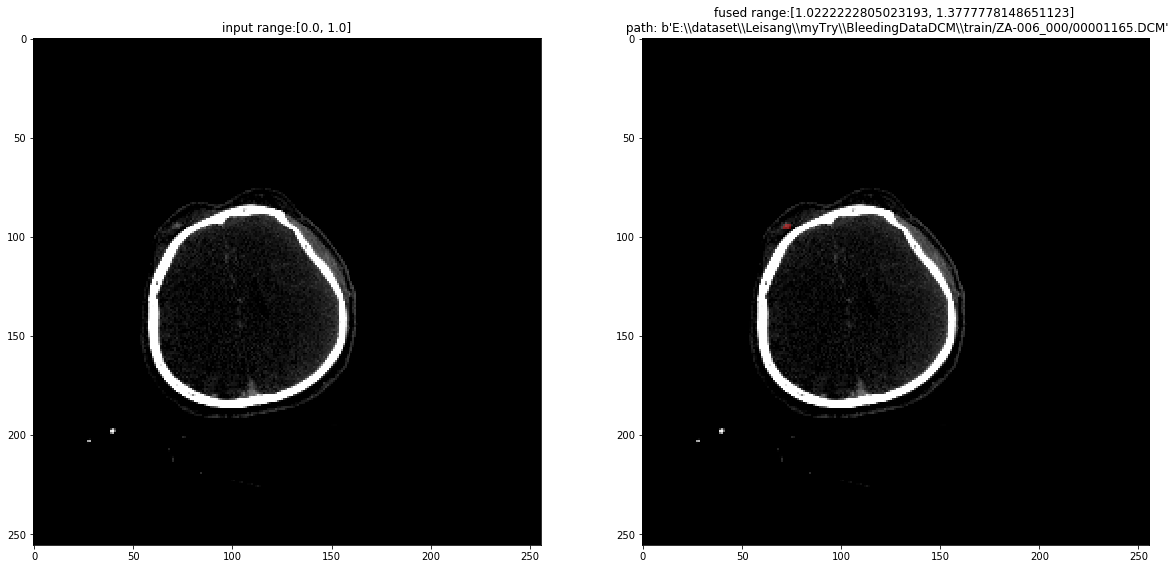

In [8]:
# # check the dataset
def plot_one_input(dicom_path, norm_input, norm_w_input, seg_label, cls_label):
    palette = copy(plt.cm.gray)
    palette.set_over('r', 1.0)
    print("dicom_path:", dicom_path)
    print("input_image.shape", norm_input.shape)
    print("seg_label", seg_label.shape)
    print("cls_label", cls_label)
    num_nonzeros=np.count_nonzero(seg_label)
    # reshape label 
    target =  tf.reshape(seg_label, norm_input.shape)
    fig, axes = plt.subplots(1,2, figsize=(20,20))
    
    norm_mask =  np.squeeze(target.numpy())
    
    norm_input = np.squeeze(norm_input.numpy())
    norm_w_input= np.squeeze(norm_w_input.numpy())

    print()
    axes[0].imshow(norm_input, cmap='gray')
    axes[0].set_title('input range:[{}, {}]'.format((norm_input.min()), np.max(norm_input)))
    axes[1].imshow(norm_mask, cmap='gray')
    axes[1].set_title('seg target range:[{}, {}] \n cls_tar: {} # of nonzeros: {}'.format(np.min(norm_mask), np.max(norm_mask), cls_label, num_nonzeros))
    
    print("norm_mask", norm_mask.shape)
    print("norm_input", norm_input.shape)
    masked_in = norm_w_input + norm_mask
    print('masked_in range:[{}, {}]'.format((masked_in.min()), masked_in.max()))

    masked = np.ma.masked_where(norm_mask==0, masked_in)  # this is only generated mask
    print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 

    
    fig2, axes2 = plt.subplots(1,2, figsize=(20,20))
    
    axes2[0].imshow(norm_w_input, cmap='gray')
    axes2[0].set_title('input range:[{}, {}]'.format((norm_w_input.min()), np.max(norm_w_input)))
    
    axes2[1].imshow(norm_w_input, cmap='gray')
    axes2[1].set_title('fused range:[{}, {}] \n path: {}'.format(np.min(masked), np.max(masked), dicom_path) )
    axes2[1].imshow(masked, palette, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
   

for dicom_paths, norm_inputs, norm_w_inputs, seg_labels, cls_labels in parsed_train_positive_dataset.take(1):
    for i in range(len(dicom_paths)):
        print("input range: [{} {}]".format(norm_inputs[i].numpy().min(), norm_inputs[i].numpy().max()))
        plot_one_input(dicom_paths[i], norm_inputs[i], norm_w_inputs[i],seg_labels[i], cls_labels[i])

## DEFINE LOAD FUNCTION IN INPUT PIPELINE

## INPUT PIPELINE

In [9]:
# balance the dataset
# lets keep the positive and negative training samples 
# positive and negative dataset will be asked by turn of batchs
train_nb_pos = 3048
train_nb_neg = 33515
rep_num = np.ceil(train_nb_neg/train_nb_pos)
print("train_nb_pos:", train_nb_pos)
print("train_nb_neg:", train_nb_neg)
print("rep_num:", rep_num)
# 
# train_dataset = tf.data.experimental.sample_from_datasets([parsed_train_positive_dataset, parsed_train_negative_dataset], weights=[0.5, 0.5])
train_positive_dataset =  parsed_train_positive_dataset
train_negative_dataset =  parsed_train_negative_dataset

train_positive_dataset = train_positive_dataset.shuffle(BUFFER_SIZE).repeat(rep_num)
train_positive_dataset = train_positive_dataset.batch(BATCH_SIZE).prefetch(4)
train_negative_dataset = train_negative_dataset.shuffle(BUFFER_SIZE)
train_negative_dataset = train_negative_dataset.batch(BATCH_SIZE).prefetch(4)


test_dataset = parsed_val_positive_dataset.concatenate(parsed_val_negative_dataset)
# test_dataset = test_dataset.shuffle(BUFFER_SIZE)  # for the random check if not comment it
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(4)


# # test positive dataset
# test_positive_dataset =  parsed_val_positive_dataset
# test_positive_dataset = test_positive_dataset.batch(BATCH_SIZE).prefetch(2)
# # test negative dataset
# test_negative_dataset =  parsed_val_negative_dataset
# test_negative_dataset = test_negative_dataset.batch(BATCH_SIZE).prefetch(2)

train_nb_pos: 3048
train_nb_neg: 33515
rep_num: 11.0


# To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each positive example once:

In [10]:
n_pos_train_batches = np.ceil(train_nb_pos*rep_num/BATCH_SIZE)
n_neg_train_batches = np.ceil(train_nb_neg/BATCH_SIZE)

val_nb_pos = 238
val_nb_neg = 4214
n_val_batches = np.ceil((val_nb_pos+val_nb_neg)/BATCH_SIZE)


n_positive_test_batches = np.ceil(val_nb_pos/BATCH_SIZE)

print("n_pos_train_batches:", n_pos_train_batches)
print("n_neg_train_batches:", n_neg_train_batches)


print("n_test_batches:", n_val_batches)

n_pos_train_batches: 16764.0
n_neg_train_batches: 16758.0
n_test_batches: 2226.0


test dicom_path shape: (2,)
test norm_inputs shape: (2, 256, 256, 1)
input range: [0.0 0.825927734375]
dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000434.DCM', shape=(), dtype=string)
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)

norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.20931372046470642, 0.27875816822052]
input range: [0.0 0.8173828125]
dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000435.DCM', shape=(), dtype=string)
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(1, shape=(), dtype=int64)

norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.308333396911621]
masked range:[1.0944443941116333, 1.308333396911621]
input range: [0.0 0.801025390625]
dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000436.DCM', shape=(), dtype=s

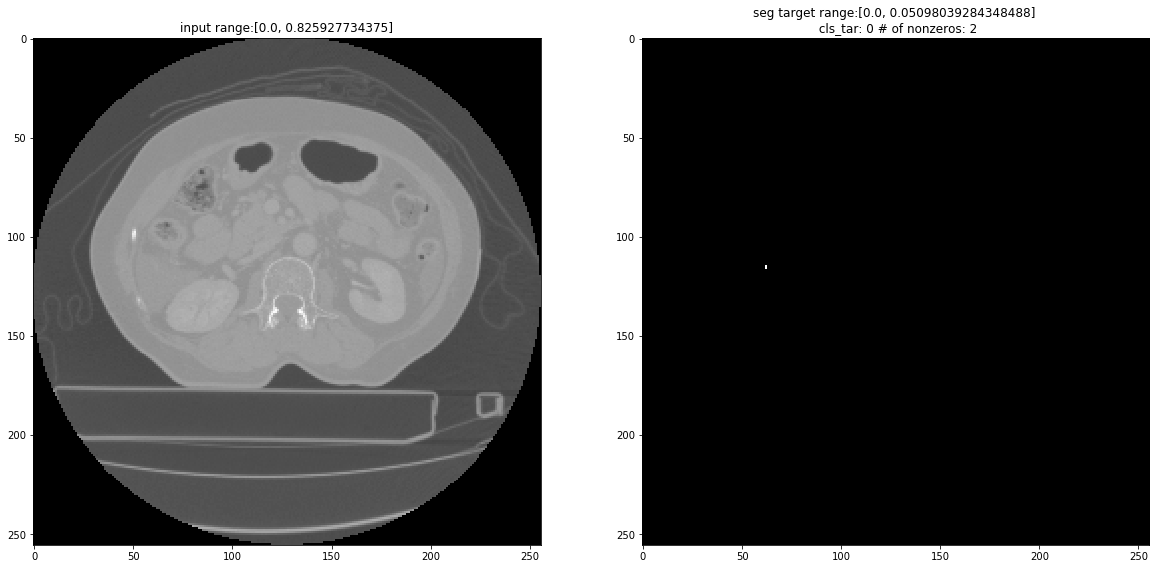

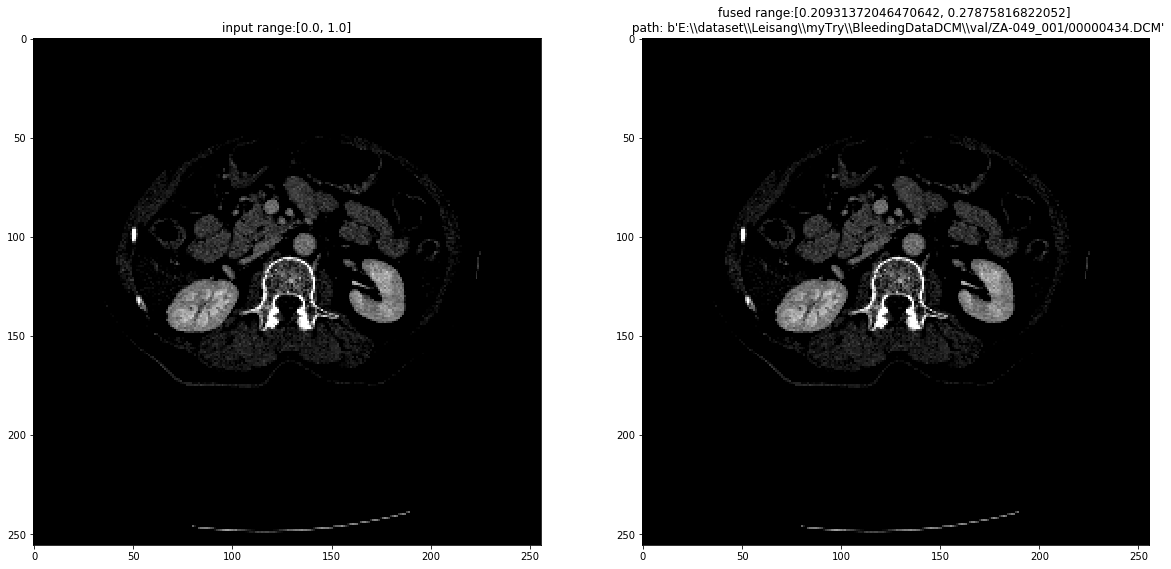

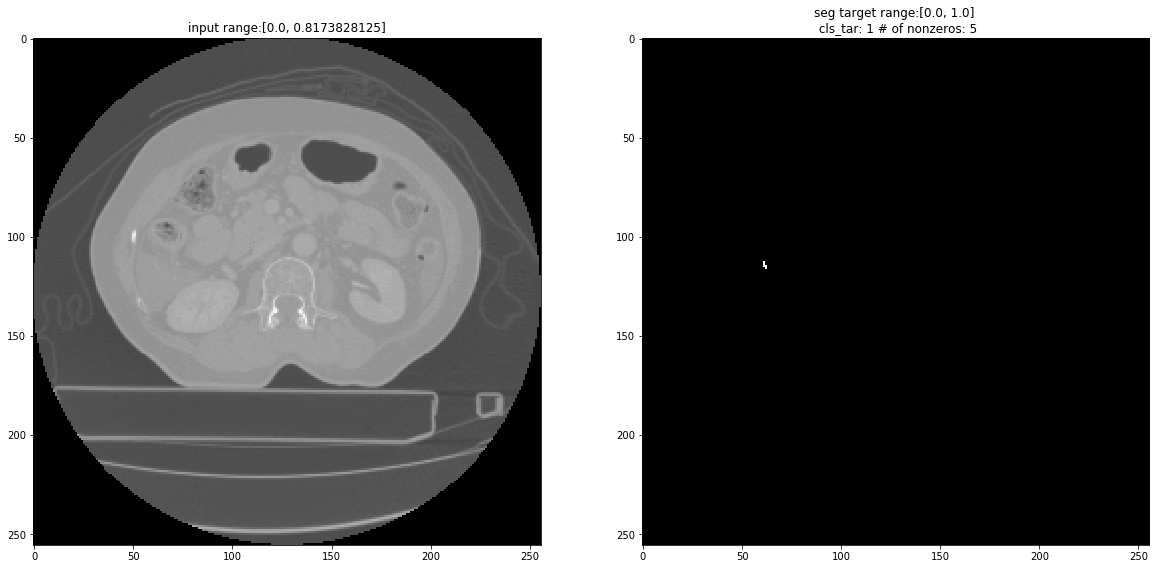

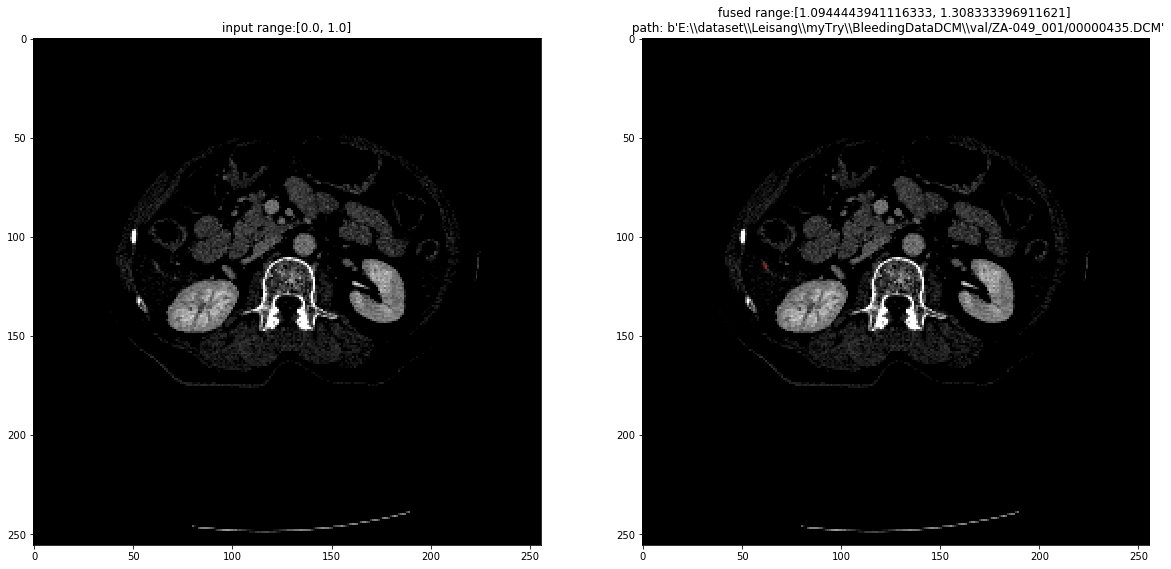

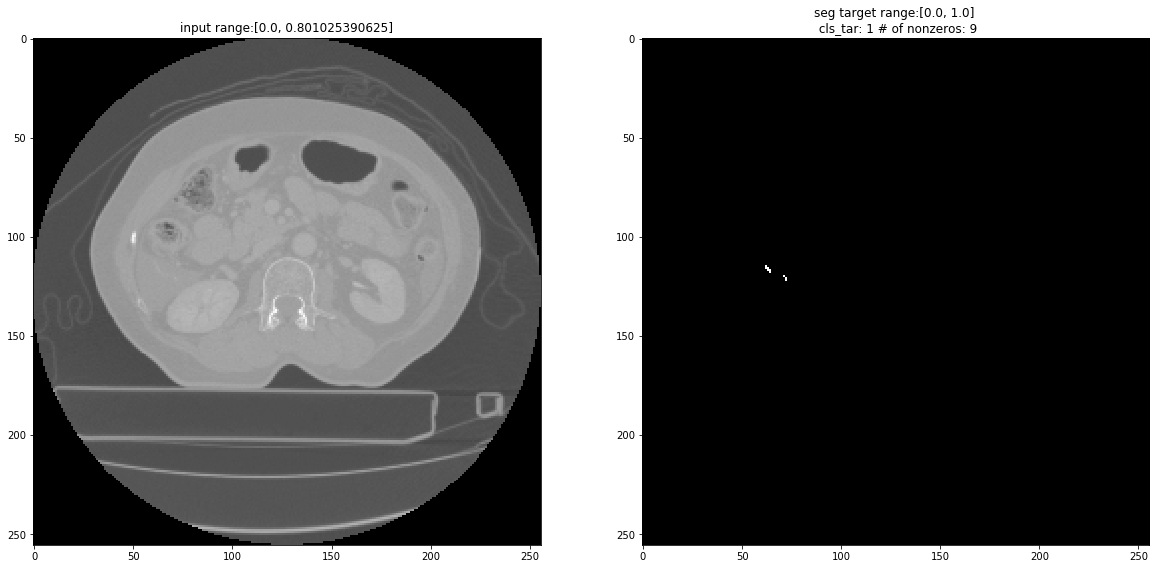

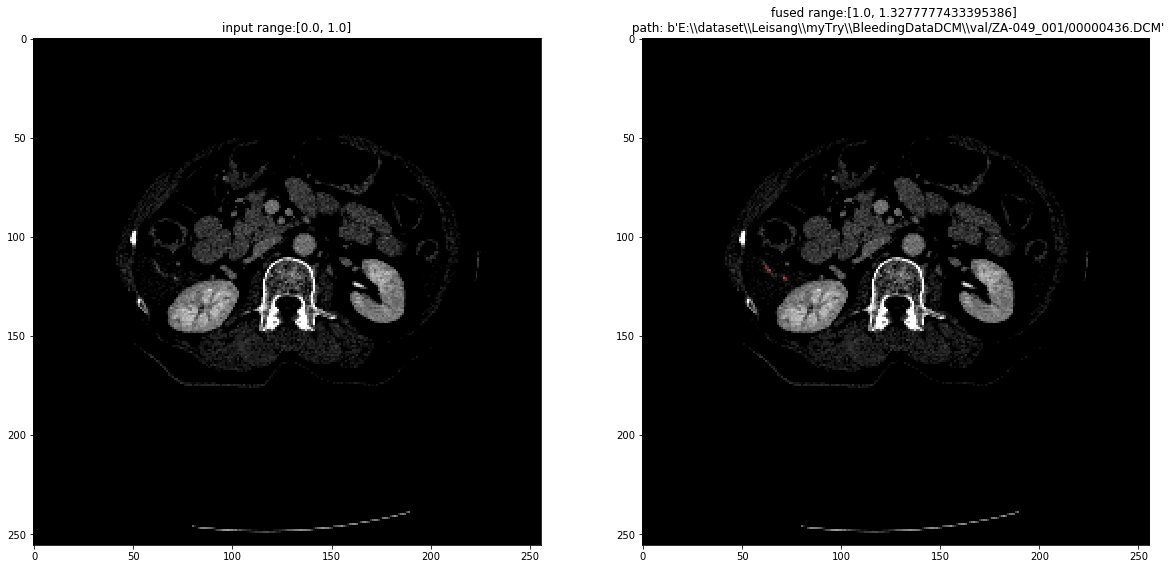

In [11]:
for dicom_paths, norm_inputs, norm_w_inputs, seg_labels, cls_labels in test_dataset.take(1): #[([batch,...]), (), ...]
    print("test dicom_path shape:", dicom_paths[0].shape)
    print("test norm_inputs shape:", norm_inputs[0].shape)
    for i in range(len(dicom_paths)):
        print("input range: [{} {}]".format(norm_inputs[i][0].numpy().min(), norm_inputs[i][0].numpy().max()))
        plot_one_input(dicom_paths[i][0], norm_inputs[i][0], norm_w_inputs[i][0],seg_labels[i][0], cls_labels[i][0])
    
    

## DESIGN MODEL

In [12]:
OUTPUT_CHANNELS = 1
latent_dim =50

In [13]:
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from tensorflow.python.keras import backend as K
# model input components
input1 = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_HEIGHT,1])
input2 = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_HEIGHT,1])
input3 = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_HEIGHT,1])

# define down_sample block as the pix-2-pix from tensorflow official set
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def feature_extractor_backbone(feb_input):
    x = downsample(64, 3, apply_batchnorm=False)(feb_input) # output  (None, 128, 128, 64)
#     skips.append(x)
    x = downsample(128, 3)(x)  # output (None, 64, 64, 128)
#     skips.append(x)
    x = downsample(256, 3)(x)  # output (None, 32, 32, 256)
    
    x = downsample(512, 3)(x)  # output (None, 16, 16, 512)
    x = downsample(1024, 3)(x)  # output (None, 8, 8, 1024)
    
    # 1x1 convol
    x = Flatten()(x)
    
#     # dense layer
    x = Dense(128, activation='relu')(x)
    
#     skips.append(x)
    # if want seperate train the generator, return the Model object e.g. return tf.keras.Model(inputs=inputs, outputs=x)
    return x


# extractor input 1
en1 = feature_extractor_backbone(input1)
en2 = feature_extractor_backbone(input2)
en3 = feature_extractor_backbone(input3)

# define euclidean_distance for dense output vectors
def euclidean_distance(vects):
    x1, x2, x3 = vects
    sum_square1 = K.sum(K.square(x1 - x2), axis=1, keepdims=True)
    sum_square3 = K.sum(K.square(x3 - x2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square1, K.epsilon())), K.sqrt(K.maximum(sum_square3, K.epsilon()))  #1e-07

# merge dense outputs from feature extractor backbones
merge_layer1,  merge_layer3= Lambda(euclidean_distance)([en1, en2, en3])

dense_d1 = Dense(64, activation="relu")(merge_layer1)
dense_d3 = Dense(64, activation="relu")(merge_layer3)

#
concat_features = Concatenate()([en1, en2, en3, dense_d1, dense_d3])

# dense_out1 = Dense(1, activation="sigmoid")(concat_features)
dense_out2 = Dense(1, activation="sigmoid")(concat_features)
# dense_out3 = Dense(1, activation="sigmoid")(concat_features)

classifier = tf.keras.Model(inputs=[input1, input2, input3], outputs=dense_out2)
             

In [14]:
# tf.keras.utils.plot_model(en1, to_file=encoder_path, show_shapes=True, dpi=64)

In [15]:
# tf.keras.utils.plot_model(en2, to_file=decoder_path, show_shapes=True, dpi=64)

In [16]:
# tf.keras.utils.plot_model(en3, to_file=autoencoder_path, show_shapes=True, dpi=64)

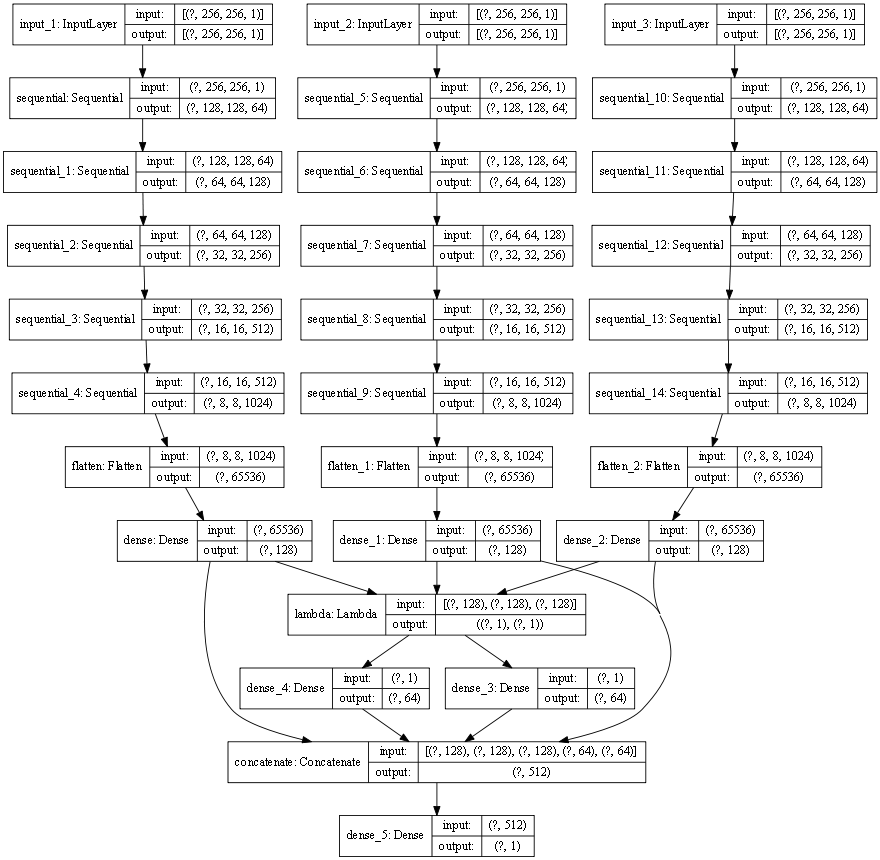

In [17]:
tf.keras.utils.plot_model(classifier, to_file=classifier_path, show_shapes=True, dpi=64)

## OPTIMIZER AND OBJECTIVE LOSSES


## Training PREPARING

In [18]:
## get current working directory
cwd = os.getcwd()
print("current working directory:", cwd)
train_full_AE_saves =  os.path.join(cwd, train_save_figure_path)
test_full_AE_saves =  os.path.join(cwd, test_save_figure_path)
print("train_full_AE_saves:", train_full_AE_saves)
print("test_full_AE_saves:", test_full_AE_saves)


if not os.path.exists(train_full_AE_saves):
    os.makedirs(train_full_AE_saves)

if not os.path.exists(test_full_AE_saves):
    os.makedirs(test_full_AE_saves)
    
    
train_predictions_save_path =os.path.join(train_full_AE_saves, "Predictions")
test_predictions_save_path =os.path.join(test_full_AE_saves, "Predictions")

test_confusion_matrix =  os.path.join(test_full_AE_saves, "Confusion_Matrix")
test_cm_diags =  os.path.join(test_full_AE_saves, "Confusion_Matrix_diagnoise_with_Epoch")

test_batch_losses =  os.path.join(test_full_AE_saves, "Test_batch_losses")

test_EpochValidation_save_path =os.path.join(test_full_AE_saves, "EpochValidation")
test_EpochValidation_save_path_pred =os.path.join(test_EpochValidation_save_path, "PredictionsOnly")
if not os.path.exists(train_predictions_save_path):
    os.makedirs(train_predictions_save_path)
if not os.path.exists(test_predictions_save_path):
    os.makedirs(test_predictions_save_path)
if not os.path.exists(test_EpochValidation_save_path):
    os.makedirs(test_EpochValidation_save_path)
if not os.path.exists(test_EpochValidation_save_path_pred):
    os.makedirs(test_EpochValidation_save_path_pred)   
if not os.path.exists(test_confusion_matrix):
    os.makedirs(test_confusion_matrix)       
if not os.path.exists(test_cm_diags):
    os.makedirs(test_cm_diags) 
if not os.path.exists(test_batch_losses):
    os.makedirs(test_batch_losses)   
    


    
    
def new_generate_images(model, dicom_paths, norm_inputs,norm_input_w_images, norm_seg_targets, cls_targets, batch_idx, epoch, save=True, Train_or_not=True, Epoch_val =False):
#     prediction = model(test_input, training=True)
  
    
    class_sigmoid_outputs = model.predict(norm_inputs)
#     print("class_sigmoid_output shape:", class_sigmoid_output)
    cls_pred =  class_sigmoid_outputs[0]
#     cls_out1 =  class_sigmoid_outputs[0]
#     cls_out2 =  class_sigmoid_outputs[1]
#     cls_out3 =  class_sigmoid_outputs[2]
#     cls_pred =  np.argmax(class_sigmoid_output[0])
    fig, axes = plt.subplots(1,3, figsize=(15,15))
    for i in range(len(dicom_paths)):
        
        
        dicom_path = dicom_paths[i][0]
        print("dicom_path", dicom_path.numpy())
        dicom_path = str(dicom_path.numpy(), 'utf-8')
        base_name =  os.path.basename(dicom_path)
        case_name = os.path.basename((os.path.dirname(dicom_path)))
        print("basename:", base_name)
        print("dri_name:", case_name)
        
        
        norm_input =norm_inputs[i][0]
        norm_w_input =norm_input_w_images[i][0]
        seg_label =norm_seg_targets[i][0]
        cls_label = cls_targets[i][0]
        
        palette = copy(plt.cm.gray)
        palette.set_over('r', 1.0)
        print("dicom_path:", dicom_path)
        print("input_image.shape", norm_input.shape)
        print("seg_label", seg_label.shape)
        print("cls_label", cls_label)
        num_nonzeros=np.count_nonzero(seg_label)
        # reshape label 
        target =  tf.reshape(seg_label, norm_input.shape)
        
#         fig, axes = plt.subplots(1,3,i+1, figsize=(20,20))

        norm_mask =  np.squeeze(target.numpy())

        norm_input = np.squeeze(norm_input.numpy())
        norm_w_input= np.squeeze(norm_w_input.numpy())

        print("norm_mask", norm_mask.shape)
        print("norm_input", norm_input.shape)
        masked_in = norm_w_input + norm_mask
        print('masked_in range:[{}, {}]'.format((masked_in.min()), masked_in.max()))

        masked = np.ma.masked_where(norm_mask==0, masked_in)  # this is only generated mask
        print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 


    

      

        axes[i].imshow(norm_w_input, cmap='gray')
        axes[i].set_title('input range:[{}, {}] \n case name: {} \n dicom: {} \n cls_tar: {} cls_pred: {}'.format(np.min(norm_input), np.max(norm_input), case_name, base_name, cls_label, cls_pred))
        axes[i].imshow(masked, palette, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    
    plt.tight_layout()
    
    if save==True :
        if Train_or_not:
            fig.savefig(train_save_figure_path + "/Train_image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
        else:
            if Epoch_val:
                fig.savefig(test_EpochValidation_save_path + "/Test_image_at_epoch_{:04d}_batch_{}_idx.png".format(epoch,batch_idx))
            else:
                fig.savefig(test_save_figure_path + "/Test_image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
     
    
    
    plt.show()

current working directory: E:\Projects\TF2\Dicom
train_full_AE_saves: E:\Projects\TF2\Dicom\300Cls256_OneShotShareRandFlipScrachStructuredBleedClassifierNoResampleONlyOutMid/AE_saves/train
test_full_AE_saves: E:\Projects\TF2\Dicom\300Cls256_OneShotShareRandFlipScrachStructuredBleedClassifierNoResampleONlyOutMid/AE_saves/test


## TRAINING

In [19]:
import datetime

# for tensorboard writers
datetime_rec =  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_summary_writer = tf.summary.create_file_writer(
  log_dir + "train")
val_summary_writer = tf.summary.create_file_writer(
  log_dir + "val")

In [20]:
# start tensorboard
# !kill 5032
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 17940), started 5:03:54 ago. (Use '!kill 17940' to kill it.)

## check the mornitoring the image

dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000434.DCM'
basename: 00000434.DCM
dri_name: ZA-049_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-049_001/00000434.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.20931372046470642, 0.27875816822052]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000435.DCM'
basename: 00000435.DCM
dri_name: ZA-049_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-049_001/00000435.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(1, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.308333396911621]
masked range:[1.0944443941116333, 1.308333396911621]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000436.DCM'
basename: 00000436.DCM

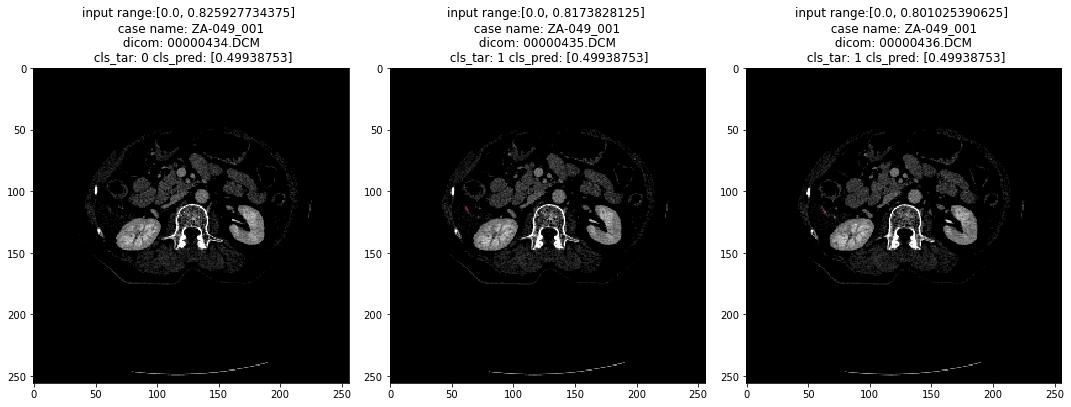

In [21]:
# base_model =  en # use encoder as the base model

# # check the loaded ae output
for dicom_paths, norm_inputs, norm_w_inputs, seg_labels, cls_labels in test_dataset.take(1):
    new_generate_images(classifier,dicom_paths, norm_inputs, norm_w_inputs, seg_labels, cls_labels,  1, 1, save=False, Train_or_not=False, Epoch_val =False)

# check the base base model traininable
# print(base_model.trainable)

# # 
# trainable_or_not =  True

# if trainable_or_not == True:
#     base_model.trainable =  True # set encoder untranable
# print("after reset basemodel trainable property:", base_model.trainable)

In [22]:
# design new loss for the new model as new_train_step, new_test_step
# new_optimizer =  tf.keras.optimizers.Adam(1e-4)
# from tf.keras.utils import to_categorical
BCE =  tf.keras.losses.BinaryCrossentropy() 
Huber =  tf.keras.losses.Huber(delta=0.1)
SCC = tf.keras.losses.SparseCategoricalCrossentropy()
@tf.function()
# define losses
def new_compute_loss(pred, cls_tar):
    
#     #seg  cross_entropy,  use reduce mean not sum, otherwise loss will be very big
#     cls_BCE_loss1 = BCE(y_true=cls_tars[0], y_pred=preds[0]) 
#     cls_BCE_loss2 = BCE(y_true=cls_tars[1], y_pred=preds[1]) 
    cls_BCE_loss = BCE(y_true=cls_tar, y_pred=pred) 
    total_loss = cls_BCE_loss
#     # L1 loss 
# #     L1_loss = tf.reduce_mean(tf.abs(x - decoded_x))
    
#     #seg Huber_loss
#     seg_Huber_loss = Huber(y_true=gt_seg, y_pred=pred_seg)
    
#     seg_total_loss = seg_Huber_loss + seg_BCE_loss
    
    
#     # use tf.keras.losses.SparseCategoricalCrossentropy instead of BCE , no need one-hot tranfermat
#     cls_SCC_loss=  SCC(y_true=gt_cls, y_pred=pred_cls)
    
#     # total_loss = cls_BCE_loss + seg_loss
#     total_loss = cls_SCC_loss 
    return total_loss
    

# def mask_to_categorical(cls_tar, num_cls=2):
#     tar = tf.one_hot(tf.cast(cls_tar, tf.int32), num_cls)
#     tar = tf.cast(tar, tf.float32)
#     return tar

# @tf.function()
def new_train_step(model, optimizer, inputs, cls_target, training):
    # change cls labe 0 or 1 into  [1, 0] [0, 1]
#     print(cls_target)
#     cls_target = mask_to_categorical(cls_target)
#     print("in trianing step")
    with tf.GradientTape() as tape:  # very interesting
        # outputs=[seg_out, class_sigmoid_output] 
        pred= model(inputs, training=training)
        total_loss = new_compute_loss(pred=pred, cls_tar=cls_target)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss

# @tf.function()
def new_test_step(model2, inputs, cls_target, training):
#     with tf.GradientTape() as tape:  # very interesting
    pred= model2(inputs, training=training)
    total_loss= new_compute_loss(pred=pred, cls_tar=cls_target)
    return total_loss, pred

## Confusion matrix define


In [23]:
!pip install scikit-learn
!pip install pandas
import sklearn.metrics
import itertools
# import seaborn as sns
import pandas as pd
def plot_confusion_matrix(cm, class_names, num_s, final_step, epoch, save=True):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes e.g, ["dog", "cat"]
    """
    figure = plt.figure(figsize=(12, 12))
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix(range[{}, {}] \n # of samples: {} toatal train steps:{})".format(cm.min(), cm.max(), num_s, final_step))
    
     # Normalize the confusion matrix.
    norm_cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    plt.imshow(norm_cm, interpolation='nearest', cmap=plt.cm.Blues)
     # Use white text if squares are dark; otherwise black.
    threshold = norm_cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if norm_cm[i, j] > threshold else "black"
        plt.text(j, i, "{}({})".format(cm[i, j],norm_cm[i, j]), horizontalalignment="center", color=color)
    plt.colorbar()  # rember the jupyter lab will remember the plt color operation so the coloar may related to the normalized value if not clean 
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names, rotation=45)

#     # Normalize the confusion matrix.
#     cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

#     # Use white text if squares are dark; otherwise black.
#     threshold = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         color = "white" if cm[i, j] > threshold else "black"
#         plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label', labelpad=0)
    plt.xlabel('Predicted label')
    if save:    
        plt.savefig(test_confusion_matrix + "/Test_cm_at_epoch_{:04d}.png".format(epoch))
    else:
        pass
    return figure



# # define calculate cm
# def log_confusion_matrix_all(model,test_inputs, cls_tar, epoch, save):
#     # Use the model to predict the values from the validation dataset.
#     class_softmax_output = model.predict(test_inputs)
#     test_pred = np.argmax(class_softmax_output, axis=1)
    
    
#     # Calculate the confusion matrix.
#     cm = sklearn.metrics.confusion_matrix(cls_tar, test_pred)


# plot diagonal of confusion matrix with respect to epoch
def log_plot_confusion_matrix_at_epochs(cm_concate_axis0, class_names, epoch, at_epoch, save=True):
    if epoch % at_epoch ==0:
        figure = plt.figure(figsize=(8, 8))
    #     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix(range[{}, {}]) at epoch {}(total {} epochs)".format(cm_concate_axis0.min(), cm_concate_axis0.max(), at_epoch, cm_concate_axis0.shape[0]))

        print("concate cm shape:",cm_concate_axis0.shape)
        # plot cm_diag vs epoch
    #     plt.plot(range(cm_concate_axis0.shape[0]), )
        for i in range(cm_concate_axis0.shape[1]):
            plt.plot(range(1, cm_concate_axis0.shape[0]+1), cm_concate_axis0[:,i], "o--", label = '{}'.format(class_names[i]))

        plt.legend(loc='best')
        plt.tight_layout()
        plt.ylabel('True diagonal probabilies', labelpad=0)
        plt.xlabel('Epochs')
        if save:    
            plt.savefig(test_cm_diags + "/Test_cm_diag_at_epoch_{:04d}.png".format(epoch))
        else:
            pass

    
def plot_batch_test_loss(test_batch_loss_catches, epoch):
    figure = plt.figure(figsize=(8, 8))
#     #     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title("test loss(range[{%.2f}, {%.2f}]) at epoch {} /n total batches:{}".format(test_batch_loss_catches.min(), test_batch_loss_catches.max(), epoch, test_batch_loss_catches.shape[1]))
#     epoch_x =  range(1, epoch+1)
#     data = {"epochs": } 
    
    data={}
#     sns.sns.boxplot(data = test_batch_loss_catches
#             ,x = 'score'
#             )
    # plot cm_diag vs epoch
    #     plt.plot(range(cm_concate_axis0.shape[0]), )

    # build dictory data for sns box plot
    for i in range(test_batch_loss_catches.shape[0]):
        data[str(i+1)] = test_batch_loss_catches[i, :]
#         x_axis =  []
#         x_axis += test_batch_loss_catches.shape[1] *[epoch]
#         print("x_axis:", x_axis)
#         plt.plot(x_axis, test_batch_loss_catches[i], "o--", label = '{}'.format(epoch))
#         plt.plot(x_axis[0], np.mean(test_batch_loss_catches), label = 'mean {%.2f} at epoch {}'.format(np.mean(test_batch_loss_catches), epoch))
#     plt.legend(loc='best')
#     plt.tight_layout()
#     plt.ylabel('Test batch loss', labelpad=0)
#     plt.xlabel('Epochs', labelpad=0)
       
#     plt.savefig(test_batch_losses + "/Test_loss_at_epoch_{:04d}.png".format(epoch))
    print("test loss data:", data)
    df = pd.DataFrame(data)
    df.plot.box(title="test batch losses per epoch")
    plt.savefig(test_batch_losses + "/Test_loss_at_epoch_{:04d}.png".format(epoch))
    
# define confusion matrix for classification displaying
def log_confusion_matrix_all(model,test_inputs, class_names,cls_tar, epoch, save):
    # Use the model to predict the values from the validation dataset.
    class_softmax_output = model.predict(test_inputs)
#     test_pred = np.argmax(class_softmax_output, axis=1)
    
    
    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(cls_tar, test_pred)
    # Log the confusion matrix as an image summary.

    figure = plot_confusion_matrix(cm, class_names, epoch, batch_indx, save)
    
    return cm
#     cm_image = plot_to_image(figure)


# def return_cls_preds_tars(single_cls_pred, single_cls_tars):
#     print("single_cls_pred:", single_cls_pred)
#     print("single_cls_tars:", single_cls_tars)

# define confusion matrix for classification displaying
def log_confusion_matrix_without_model(cls_preds, class_names,cls_tars, final_step, epoch, save):
    # Use the model to predict the values from the validation dataset.
#     seg_out, class_softmax_output = model.predict(test_inputs)
    
    # check the number of samples
    num_s =  cls_preds.shape[0]
    # binarize the preds
    cls_preds = cls_preds>0.5
    
    
#     cls_preds_ints = np.argmax(cls_preds, axis=1)
#     print("cls_preds_ints:", cls_preds_ints, cls_preds_ints.shape)
#     print("cls_tars:", cls_tars, cls_tars.shape)
    
    # Calculate the confusion matrix.
#     cm = sklearn.metrics.confusion_matrix(cls_tars, cls_preds_ints,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cm = sklearn.metrics.confusion_matrix(cls_tars, cls_preds,  labels=[0, 1])  # for binary classification : cls_preds should not be probability ,has  to be either 1s or 0
    print("cm:", cm)
    # Log the confusion matrix as an image summary.

    figure = plot_confusion_matrix(cm, class_names, num_s,final_step, epoch, save)
    
    # calcualte norm cm for the later diagnal plots
    norm_cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    return norm_cm
#     cm_image = plot_to_image(figure)

In [24]:
def write_losses_tb(writer, avg_losses, epoch):
    """
     avg_losses = [total_loss, seg_loss, cls_loss]
    """
    with writer.as_default():
        print("writing train logs to tensorboard...")                                                       
        # write scalars to the tensorboard after each train step
        tf.summary.scalar('total_loss', avg_losses[0].result(), step=epoch)
        tf.summary.scalar('cls_BCE_loss1', avg_losses[1].result(), step=epoch)
        tf.summary.scalar('cls_BCE_loss2', avg_losses[2].result(), step=epoch) 
        tf.summary.scalar('cls_BCE_loss3', avg_losses[3].result(), step=epoch)
        
        
def train_display_save_at(model, Tr_dicom_paths, Tr_norm_input, Tr_norm_input_w_image, Tr_norm_seg_label,Tr_cls_label,   step, epoch, freq_step =100, save=True, Train_or_not=True):
    if step % freq_step == 0 or step % (freq_step+1) ==0:
        print("train image checking----------------------------------------------------------------------------------->")
#        (model, dicom_paths, norm_inputs,norm_input_w_images, norm_seg_targets, cls_targets, batch_idx, epoch, save=True, Train_or_not=True, Epoch_val =False
        new_generate_images(model, Tr_dicom_paths, Tr_norm_input,Tr_norm_input_w_image, Tr_norm_seg_label,Tr_cls_label,  step, epoch, save=save, Train_or_not=Train_or_not)
#         print('Epoch{}: {}/{}: total_loss: {}; cls_SCE_loss: {}; seg_total_loss: {} '.format(epoch, step, resampled_steps_per_epoch, total_loss, cls_SCE_loss, seg_total_loss))
        
# def test_display_save_at(val_dataset, model, step, epoch, freq_step= 100, save=True, Train_or_not=False):
#     # every 100 batch step show the generate test image to check.
#     if int(step) % freq_step == 0:
#         display.clear_output(wait=True)
           
#         # take the 1st batch from the validation dataset
#         for image_featuresx in val_dataset.take(1):

# #         print("test input:", image_features3)
#         # feature extraction
# #             TE_dicom_path3 =  image_features3[0]
#             Tex_input_w_image =  image_featuresx[1]
#             tex_input =  image_featuresx[2]
#             Tex_seg_label = image_featuresx[3]
#             tex_target = image_featuresx[4]
# #         for tex_input, tex_target in test_dataset.take(1):
 
#             #         plt.figure()
#             #         plt.imshow(np.squeeze(tex_input[0]))
#             #         plt.colorbar()
#             #         plt.grid(False)
#             #         plt.title(str(tex_target[0].numpy()))
#             #         plt.show()
# #           
#             print("The 1st batch test image checking----------------------------------------------------------------------------------->")
#             new_generate_images(model, tex_input,Tex_input_w_image, Tex_seg_label, tex_target,step, epoch, save=save, Train_or_not=Train_or_not)
            # every 400 steps save the genrate images



def test_at_each_epoch(val_dataset, model, step, epoch, temp_loss,save=True, training=False):
    # initialize 
    epoch_val_flag = True
    # initialize for evaluating average metric
    test_total_loss_mean = tf.keras.metrics.Mean()
#     test_cls_BCE_loss1_mean = tf.keras.metrics.Mean()
#     test_cls_BCE_loss2_mean = tf.keras.metrics.Mean()
#     test_cls_BCE_loss3_mean = tf.keras.metrics.Mean()
    # 
    cls_preds_entire = None
    cls_tar_entire = None
    
#     #
    test_loss_catches = []
#     print(loss_catches.shape)


    # start to go through entire validation dataset
#     for  image_features3 in val_dataset.take(10):     # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#     for tex_input, tex_target in test_dataset.take(1):  
    count =0
    for dicom_paths, norm_inputs, norm_w_inputs, seg_labels, cls_labels in val_dataset:
        count+=1
        # one train step loss calculation and optimization  model2, inputs, cls_target, training
        te_total_loss, pred = new_test_step(model, norm_inputs, cls_labels[1], training=False)
        test_total_loss_mean(te_total_loss)
        test_loss_catches.append(te_total_loss)
#         test_cls_BCE_loss1_mean(te_cls_BCE_loss1)
#         test_cls_BCE_loss2_mean(te_cls_BCE_loss2)
#         test_cls_BCE_loss3_mean(te_cls_BCE_loss3)
        
        print('[Test]Epoch: {} batch:{} \n  total_loss set loss: {}'.format(epoch, count, test_total_loss_mean.result()))
        
        if count %25 ==0:
            display.clear_output(wait=True)
        
     
        
        # save epoch validation image in the folder every 10 batches save
        
#         if idx >10:  # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#             break    # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
        
        if count > n_positive_test_batches:  # when  evaluating negative val dataset using larger spacing
            
            if count % 500 ==0:
                # (model, dicom_paths, norm_inputs,norm_input_w_images, norm_seg_targets, cls_targets, batch_idx, epoch, save=True, Train_or_not=True, Epoch_val =False
                new_generate_images(model, dicom_paths, norm_inputs, norm_w_inputs, seg_labels, cls_labels , count,
                                    epoch, save=save, Train_or_not=training, Epoch_val=epoch_val_flag) 
           
        else:
            new_generate_images(model, dicom_paths,norm_inputs,  norm_w_inputs, seg_labels, cls_labels ,count, 
                                epoch, save=save, Train_or_not=training, Epoch_val=epoch_val_flag)                                               
#         display.clear_output(wait=True)

         # Test input--------------batch input and targets to evaluate confusion matrix====================》
        cls_preds = pred # predicts has shape [batch size, len(classes)]
#         print("single batch targets shape:", cls_labels.shape)
#         print("single batch preds shape:", cls_preds.shape)
        if cls_preds_entire is None:
            cls_preds_entire = cls_preds
            cls_tar_entire = cls_labels[1].numpy()
# #                   
        else: 
            cls_preds_entire =  np.concatenate((cls_preds_entire, cls_preds), axis=0)
            cls_tar_entire = np.concatenate((cls_tar_entire, cls_labels[1].numpy()), axis=0)
            
# #         idx +=1       # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
            
    print("preds_entire.shape", cls_preds_entire, cls_preds_entire.shape)
    print("cls_entire.shape", cls_tar_entire, cls_tar_entire.shape)   # https://www.tensorflow.org/tensorboard/image_summaries

    
    # log the norm
    norm_cm = log_confusion_matrix_without_model(cls_preds=cls_preds_entire, class_names=Class_names, cls_tars=cls_tar_entire, final_step =step, epoch=epoch, save=save)

    epoch_val_flag = False # one epoch finish so set flag back
    
    
#     # write logs to tensorboard:    avg_losses = [total_loss, seg_loss, cls_loss]
#     # write test losses to the tensorboard
    print("writing test logs to tensorboard...") 
    write_losses_tb(val_summary_writer, [test_total_loss_mean, test_cls_BCE_loss1_mean, test_cls_BCE_loss2_mean,test_cls_BCE_loss3_mean], epoch)

  
    # check whether needs to save the model
    if test_total_loss_mean.result() < temp_loss:
        save_path =  new_manager.save() # save the checkpoint and return the save path
        print("Saved checkpoint for epoch {}-  step {}: {}".format(epoch, step, save_path))
        temp_loss =  test_total_loss_mean.result()

    return norm_cm,   np.array(test_loss_catches).reshape((1,-1))

# defin one epoch training for different dataset
def train_one_epoch(train_pos_dataset, train_neg_dataset, model, optimizer, step, epoch):
    #  initializations at each epoch
    tr_pos_iter= iter(train_pos_dataset)
    tr_neg_iter= iter(train_neg_dataset)
    train_total_loss_mean = tf.keras.metrics.Mean()
    
    for i in range(1, int(2* n_neg_train_batches)+1):
        if i > 500:  # for debug
            break 
        if step % 2==0:
            train_dataset_itr = tr_pos_iter
        else: 
            train_dataset_itr = tr_neg_iter
    
        dicom_paths, norm_inputs, norm_w_inputs, seg_labels, cls_labels  = next(train_dataset_itr)
           
        # one train step loss calculation and optimization
        tr_total_loss = new_train_step(model, optimizer, norm_inputs, cls_labels[1], training=True)
        train_total_loss_mean(tr_total_loss)

        print('Epoch: {} batch:{} \n Train total_loss set loss: {}'.format(epoch, int(step), train_total_loss_mean.result()))

        #  model, Tr_dicom_paths, Tr_norm_input, Tr_norm_input_w_image, Tr_norm_seg_label,Tr_cls_label,   step, epoch, freq_step =100, save=True, Train_or_not=True
        train_display_save_at(model, dicom_paths, norm_inputs, norm_w_inputs, seg_labels, cls_labels,  int(step), epoch, freq_step=200, save=True, Train_or_not=True )
        
        if step % 25 ==0:
            display.clear_output(wait=True)
        
        step.assign_add(1)

In [25]:
# take_new_train_batches =  3035
def train_process(train_pos_dataset, train_neg_dataset, val_dataset, model, optimizer, step, start_epoch, total_epochs):
    # some initial parameters
    # test average_loss = for saving the test results
    test_avg_tmp_loss = 100
    norm_cm_diags = None   
   
    test_loss_epochs = None
    for epoch in range(int(start_epoch), total_epochs+1):
       
    
        # train one epoch， including loss calculation and optimization
        train_one_epoch(train_pos_dataset, train_neg_dataset, model, optimizer, step, epoch)
        
        # one training epoch ended start to evaluate the performance through entire test dataset
        each_epoch_norm_cm, test_loss_catches_per_epoch = test_at_each_epoch(val_dataset, model, int(step)-1, epoch, temp_loss=test_avg_tmp_loss, save=True, training = False)
        
        # calculate epoch diagnals of confucion matrix
        print("test_loss_catches_per_epoch.shape:", test_loss_catches_per_epoch.shape)
        norm_cm_diag_each_epoch = np.reshape(np.diag(each_epoch_norm_cm),(1, -1))
        
        if norm_cm_diags is None:
            norm_cm_diags =  norm_cm_diag_each_epoch
        else:
            norm_cm_diags=  np.concatenate((norm_cm_diags, norm_cm_diag_each_epoch ), axis = 0)
            
        log_plot_confusion_matrix_at_epochs(norm_cm_diags, Class_names, epoch, at_epoch=7, save=True)
        
        # accumulated epoch loss
        if test_loss_epochs is  None:
            test_loss_epochs = test_loss_catches_per_epoch
        else:
            test_loss_epochs=  np.concatenate((test_loss_epochs,test_loss_catches_per_epoch ), axis = 0)
            
        # plot tepoch test losses
        plot_batch_test_loss(test_loss_epochs, epoch)
        
        # write train epoch average loss to the tensorboard
        print("writing train logs to tensorboard...") 
        write_losses_tb(train_summary_writer, [train_total_loss_mean, train_cls_BCE_loss1_mean, train_cls_BCE_loss2_mean, train_cls_BCE_loss3_mean], epoch)
            
      
        # when epoch fisnihed add epoch counter and reset the batch step 
        start_epoch.assign_add(1)     
        step.assign(1)
        
        
    # when training finihsed
    print("training finished") 


dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001158.DCM'
basename: 00001158.DCM
dri_name: ZA-053_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-053_001/00001158.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.0, 0.0]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001159.DCM'
basename: 00001159.DCM
dri_name: ZA-053_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-053_001/00001159.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.0, 0.0]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001160.DCM'
basename: 00001160.DCM
dri_name: ZA-053_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataD

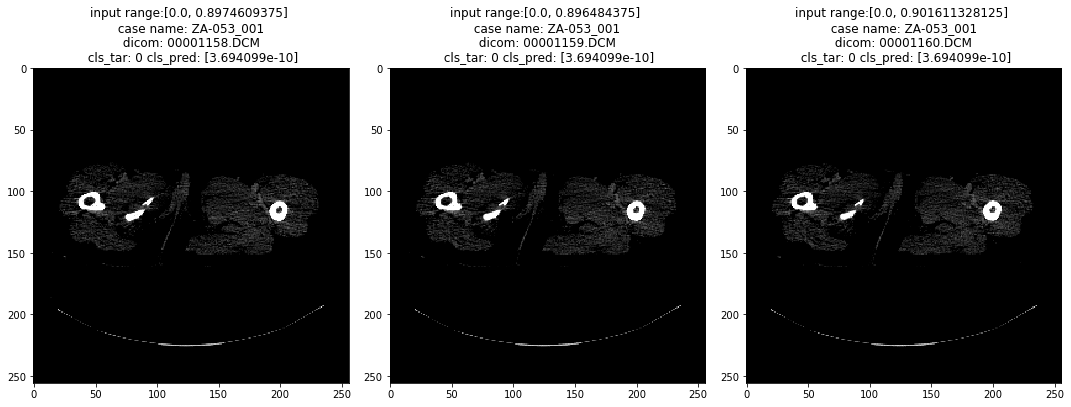

[Test]Epoch: 1 batch:1751 
  total_loss set loss: 1.0438919067382812
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001160.DCM'
basename: 00001160.DCM
dri_name: ZA-053_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-053_001/00001160.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.0, 0.0]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001161.DCM'
basename: 00001161.DCM
dri_name: ZA-053_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-053_001/00001161.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.0, 0.0]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001162.DCM'
basename: 00001162.DCM
dr

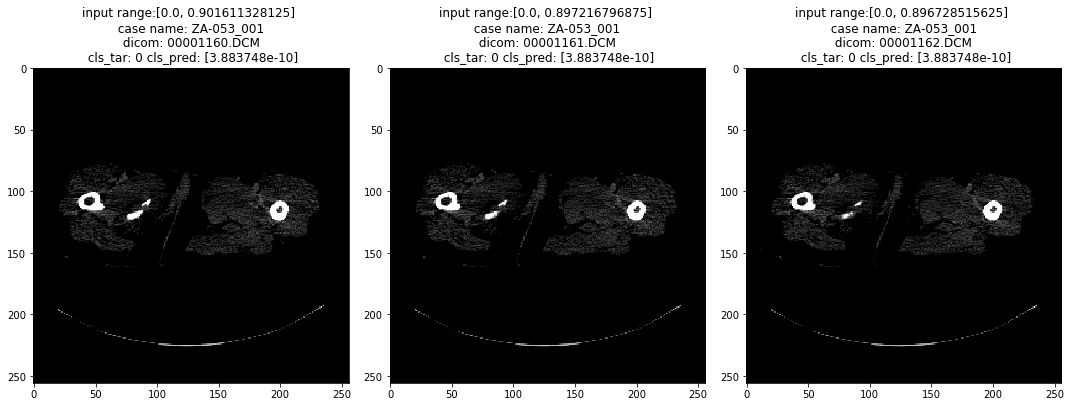

[Test]Epoch: 1 batch:1752 
  total_loss set loss: 1.0432960987091064
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001162.DCM'
basename: 00001162.DCM
dri_name: ZA-053_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-053_001/00001162.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.0, 0.0]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001163.DCM'
basename: 00001163.DCM
dri_name: ZA-053_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-053_001/00001163.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.0, 0.0]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001164.DCM'
basename: 00001164.DCM
dr

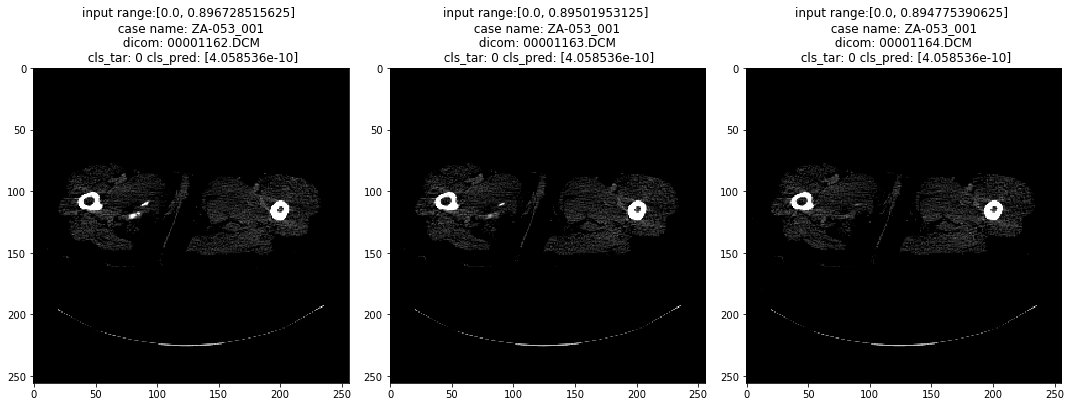

[Test]Epoch: 1 batch:1753 
  total_loss set loss: 1.0427008867263794
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001164.DCM'
basename: 00001164.DCM
dri_name: ZA-053_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-053_001/00001164.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.0, 0.0]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001165.DCM'
basename: 00001165.DCM
dri_name: ZA-053_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-053_001/00001165.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.0, 0.0]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001166.DCM'
basename: 00001166.DCM
dr

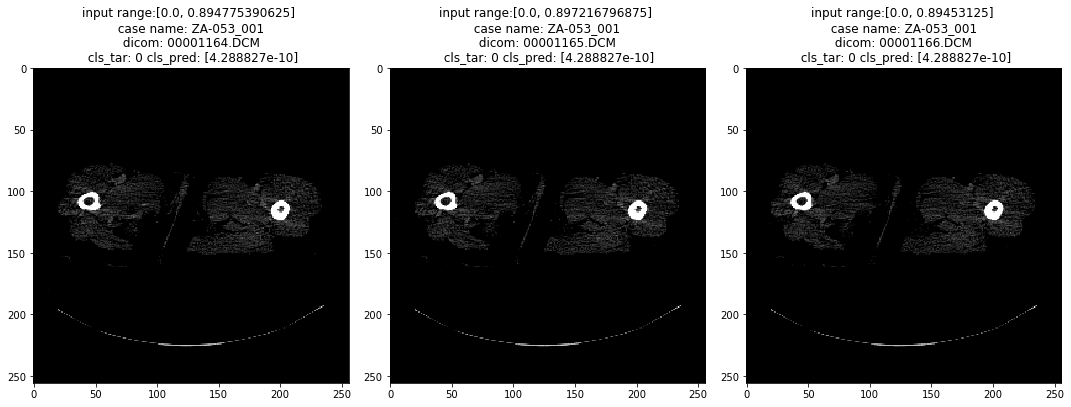

[Test]Epoch: 1 batch:1754 
  total_loss set loss: 1.0421065092086792
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001166.DCM'
basename: 00001166.DCM
dri_name: ZA-053_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-053_001/00001166.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.0, 0.0]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001167.DCM'
basename: 00001167.DCM
dri_name: ZA-053_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-053_001/00001167.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.0, 0.0]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001168.DCM'
basename: 00001168.DCM
dr

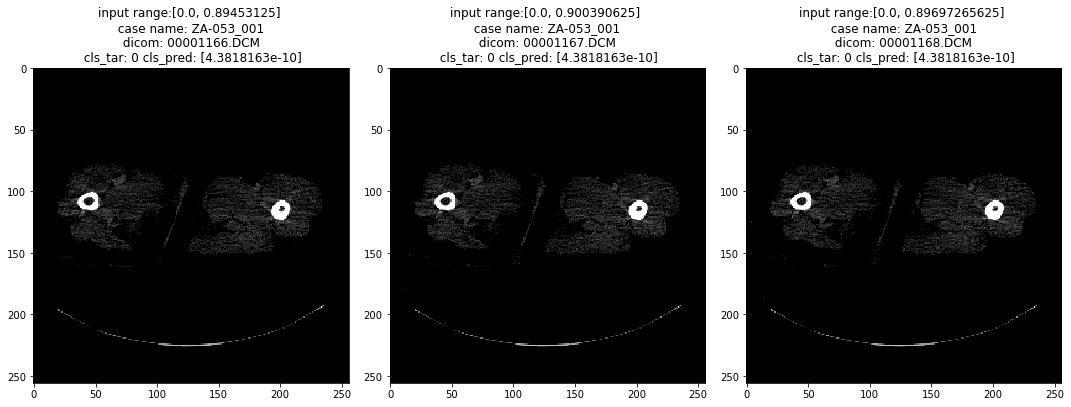

[Test]Epoch: 1 batch:1755 
  total_loss set loss: 1.0415127277374268
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001168.DCM'
basename: 00001168.DCM
dri_name: ZA-053_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-053_001/00001168.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.0, 0.0]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001169.DCM'
basename: 00001169.DCM
dri_name: ZA-053_001
dicom_path: E:\dataset\Leisang\myTry\BleedingDataDCM\val/ZA-053_001/00001169.DCM
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(0, shape=(), dtype=int64)
norm_mask (256, 256)
norm_input (256, 256)
masked_in range:[0.0, 1.0]
masked range:[0.0, 0.0]
dicom_path b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-053_001/00001170.DCM'
basename: 00001170.DCM
dr

KeyboardInterrupt: 

In [26]:
import time
if __name__ == "__main__":
    new_optimizer =  tf.keras.optimizers.Adam(1e-4)
    # build_new check point manager
    new_ckpt_prefix = os.path.join(checkpoint_dir, "ckpt")
    if not os.path.exists(new_ckpt_prefix):
        os.makedirs(new_ckpt_prefix)
    #  contents of states to be saved as attributes on the checkpoint object
    new_ckpt_ob = tf.train.Checkpoint(step= tf.Variable(1),
                                        epoch=  tf.Variable(1),
                                        optimizer=new_optimizer,
                                         model =  classifier
                                     )
    # define checkpoint manager
    new_manager =  tf.train.CheckpointManager(new_ckpt_ob, new_ckpt_prefix, max_to_keep=1)

    # check the whether there is a checkpoint in the checkpoint folder, if it is restore from it
    if new_manager.latest_checkpoint:
        print("Restored from {}".format(new_manager.latest_checkpoint))
        new_ckpt_ob.restore(new_manager.latest_checkpoint)
    else:
        print("Initializing from scratch.")

    # reset checkcpoint.step for each epoch
    step =  new_ckpt_ob.step
    ckpt_epoch =  new_ckpt_ob.epoch  
    optimizer = new_ckpt_ob.optimizer
    model = new_ckpt_ob.model
    epochs =  200
    # start train_process
    train_process(train_positive_dataset, train_negative_dataset, test_dataset, model, optimizer, step, ckpt_epoch, total_epochs=epochs)
